# DYNAMIC PRICING ENGINE - JETTO.ID
## Data preparationn


**Disusun Oleh:**
- Danendra Pandya Reswara (123230169)
- Adam Fauzan Waskito (123230178)
- Muhammad Ridhwan Fahmi R (123230179)

**Program Studi Informatika**  
**Universitas Pembangunan Nasional "Veteran" Yogyakarta**  
**2025**


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


## Setup & Konfigurasi Visualisasi


In [42]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



### 1. Pemuatan Data & Inspeksi Awal

- Memuat dataset dari file CSV
- Melihat struktur dan dimensi data
- Mengecek tipe data dan penggunaan memori
- Melihat statistik deskriptif dasar


In [43]:
print("\n" + "="*60)
print("1. DATA LOADING & INITIAL INSPECTION")
print("="*60)

df = pd.read_csv('data.csv', encoding='ISO-8859-1')

print(f"\n✓ Dataset berhasil dimuat!")
print(f"  Dimensi: {df.shape[0]:,} baris × {df.shape[1]} kolom")

print(f"\n{'='*60}")
print("GAMBARAN UMUM DATASET")
print("="*60)
print(df.head(10))

print(f"\n{'='*60}")
print("TIPE DATA & PENGGUNAAN MEMORI")
print("="*60)
print(df.info())

print(f"\n{'='*60}")
print("STATISTIK DESKRIPTIF")
print("="*60)
print(df.describe())



1. DATA LOADING & INITIAL INSPECTION

✓ Dataset berhasil dimuat!
  Dimensi: 541,909 baris × 8 kolom

GAMBARAN UMUM DATASET
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       

---
## 2. Penilaian Kualitas Data

- **Missing Values** - Data yang hilang
- **Duplicate Records** - Data duplikat
- **Data Anomalies** - Anomali seperti nilai negatif, harga nol, dan transaksi yang dibatalkan


In [44]:
print(f"\n{'='*60}")
print("2. DATA QUALITY ASSESSMENT")
print("="*60)

print("\nAnalisis Missing Values:")
missing_data = pd.DataFrame({
    'Kolom': df.columns,
    'Jumlah_Missing': df.isnull().sum(),
    'Persentase_Missing': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Jumlah_Missing'] > 0].sort_values('Persentase_Missing', ascending=False)
print(missing_data.to_string(index=False))

duplicates = df.duplicated().sum()
print(f"\n✓ Baris Duplikat: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

print(f"\n{'='*60}")
print("DETEKSI ANOMALI DATA")
print("="*60)

negative_qty = (df['Quantity'] < 0).sum()
print(f"• Quantity Negatif (Pengembalian): {negative_qty:,}")

zero_price = (df['UnitPrice'] == 0).sum()
print(f"• Unit Price Nol: {zero_price:,}")

cancelled = df['InvoiceNo'].astype(str).str.startswith('C').sum()
print(f"• Transaksi Dibatalkan: {cancelled:,}")



2. DATA QUALITY ASSESSMENT

Analisis Missing Values:
      Kolom  Jumlah_Missing  Persentase_Missing
 CustomerID          135080               24.93
Description            1454                0.27

✓ Baris Duplikat: 5,268 (0.97%)

DETEKSI ANOMALI DATA
• Quantity Negatif (Pengembalian): 10,624
• Unit Price Nol: 2,515
• Transaksi Dibatalkan: 9,288


---
## 3. Data Cleaning
### Pembersihan Data
- Menghapus transaksi yang dibatalkan
- Menghapus pengembalian barang (quantity negatif)
- Menghapus harga nol
- Menghapus data dengan deskripsi kosong
- Konversi format tanggal
- Menghapus outlier ekstrem menggunakan metode IQR


In [45]:
print(f"\n{'='*60}")
print("3. DATA CLEANING")
print("="*60)

df_clean = df.copy()

df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"✓ Menghapus transaksi yang dibatalkan: {len(df) - len(df_clean):,} baris")

df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"✓ Menghapus pengembalian (quantity negatif)")

df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"✓ Menghapus harga nol")

df_clean = df_clean.dropna(subset=['Description'])
print(f"✓ Menghapus deskripsi kosong")

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
print(f"✓ Konversi InvoiceDate ke format datetime")

def remove_outliers_iqr(df, column, multiplier=3.0):
    """Menghapus outlier menggunakan Interquartile Range (IQR) method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

original_len = len(df_clean)
df_clean = remove_outliers_iqr(df_clean, 'Quantity', multiplier=3.0)
df_clean = remove_outliers_iqr(df_clean, 'UnitPrice', multiplier=3.0)
print(f"✓ Menghapus outlier ekstrem: {original_len - len(df_clean):,} baris")

print(f"\nDimensi Dataset Bersih: {df_clean.shape[0]:,} baris × {df_clean.shape[1]} kolom")



3. DATA CLEANING
✓ Menghapus transaksi yang dibatalkan: 9,288 baris
✓ Menghapus pengembalian (quantity negatif)
✓ Menghapus harga nol
✓ Menghapus deskripsi kosong
✓ Konversi InvoiceDate ke format datetime
✓ Menghapus outlier ekstrem: 32,696 baris

Dimensi Dataset Bersih: 497,408 baris × 8 kolom


---
## 4. Exploratory Data Analysis (EDA)
### Analisis Eksplorasi Data
- **4.1 Temporal Analysis** - Analisis pola waktu
- **4.2 Product Analysis** - Analisis produk
- **4.3 Price Distribution** - Distribusi harga
- **4.4 Geographic Analysis** - Analisis geografis


In [46]:
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"\n{'='*60}")
print("4. EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)
print(f"✓ Kolom Revenue berhasil dibuat")



4. EXPLORATORY DATA ANALYSIS (EDA)
✓ Kolom Revenue berhasil dibuat


### 4.1 Temporal Analysis
**Analisis Pola Waktu**

Menganalisis distribusi transaksi berdasarkan:
- Rentang waktu data
- Hari dalam seminggu
- Jam dalam sehari
- Weekend vs Weekday


In [47]:
print("\n4.1 ANALISIS TEMPORAL (TEMPORAL ANALYSIS)")
print("-" * 60)

df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin(['Saturday', 'Sunday'])

print(f"Rentang Tanggal: {df_clean['InvoiceDate'].min()} sampai {df_clean['InvoiceDate'].max()}")
print(f"\nTransaksi Berdasarkan Hari:")
print(df_clean['DayOfWeek'].value_counts().sort_index())

print(f"\nTransaksi Berdasarkan Jam:")
hourly_dist = df_clean['Hour'].value_counts().sort_index()
print(hourly_dist.head(10))



4.1 ANALISIS TEMPORAL (TEMPORAL ANALYSIS)
------------------------------------------------------------
Rentang Tanggal: 2010-12-01 08:26:00 sampai 2011-12-09 12:50:00

Transaksi Berdasarkan Hari:
DayOfWeek
Friday       75215
Monday       87487
Sunday       61845
Thursday     94148
Tuesday      92700
Wednesday    86013
Name: count, dtype: int64

Transaksi Berdasarkan Jam:
Hour
6         1
7       233
8      8016
9     30945
10    43370
11    52298
12    72894
13    67496
14    62453
15    71747
Name: count, dtype: int64


### 4.2 Product Analysis
**Analisis Produk**

Mengidentifikasi:
- Jumlah produk unik
- Produk dengan revenue tertinggi
- Produk paling populer berdasarkan transaksi


In [48]:
print("\n4.2 ANALISIS PRODUK (PRODUCT ANALYSIS)")
print("-" * 60)

print(f"Total Produk Unik: {df_clean['StockCode'].nunique():,}")
print(f"Total Deskripsi Unik: {df_clean['Description'].nunique():,}")

top_products = df_clean.groupby('Description').agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'count'
}).sort_values('Revenue', ascending=False).head(10)
top_products.columns = ['Total_Revenue', 'Total_Quantity', 'Jumlah_Transaksi']
print(f"\nTop 10 Produk Berdasarkan Revenue:")
print(top_products)



4.2 ANALISIS PRODUK (PRODUCT ANALYSIS)
------------------------------------------------------------
Total Produk Unik: 3,851
Total Deskripsi Unik: 3,955

Top 10 Produk Berdasarkan Revenue:
                                    Total_Revenue  Total_Quantity  \
Description                                                         
REGENCY CAKESTAND 3 TIER                109015.82            9319   
WHITE HANGING HEART T-LIGHT HOLDER       57061.26           19642   
PARTY BUNTING                            50629.16            8772   
JUMBO BAG RED RETROSPOT                  35492.46           15637   
SPOTTY BUNTING                           30609.41            5527   
ASSORTED COLOUR BIRD ORNAMENT            30411.73           17661   
JAM MAKING SET WITH JARS                 27634.90            6270   
CHOCOLATE HOT WATER BOTTLE               26950.52            4748   
SET OF 3 CAKE TINS PANTRY DESIGN         26750.07            5065   
CHILLI LIGHTS                            26152.26  

### 4.3 Price Distribution Analysis
**Analisis Distribusi Harga**

Menganalisis:
- Statistik harga (min, max, mean, median)
- Segmentasi harga produk
- Pola distribusi harga


In [49]:
print("\n4.3 ANALISIS DISTRIBUSI HARGA (PRICE DISTRIBUTION)")
print("-" * 60)

price_stats = df_clean['UnitPrice'].describe()
print("Statistik Unit Price:")
print(price_stats)

df_clean['PriceSegment'] = pd.cut(df_clean['UnitPrice'], 
                                   bins=[0, 2, 5, 10, 50, 1000],
                                   labels=['Sangat Rendah (0-2)', 'Rendah (2-5)', 'Menengah (5-10)', 
                                          'Tinggi (10-50)', 'Sangat Tinggi (50+)'])

print(f"\nDistribusi Segmen Harga:")
print(df_clean['PriceSegment'].value_counts().sort_index())



4.3 ANALISIS DISTRIBUSI HARGA (PRICE DISTRIBUTION)
------------------------------------------------------------
Statistik Unit Price:
count    497408.000000
mean          2.982119
std           2.573986
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max          12.750000
Name: UnitPrice, dtype: float64

Distribusi Segmen Harga:
PriceSegment
Sangat Rendah (0-2)    233400
Rendah (2-5)           191058
Menengah (5-10)         61302
Tinggi (10-50)          11648
Sangat Tinggi (50+)         0
Name: count, dtype: int64


### 4.4 Geographic Analysis
**Analisis Geografis**

Menganalisis:
- Jumlah negara yang terlibat
- Negara dengan transaksi terbanyak
- Distribusi geografis penjualan


In [50]:
print("\n4.4 ANALISIS GEOGRAFIS (GEOGRAPHIC ANALYSIS)")
print("-" * 60)

print(f"Total Negara: {df_clean['Country'].nunique()}")
print(f"\nTop 10 Negara Berdasarkan Jumlah Transaksi:")
country_stats = df_clean['Country'].value_counts().head(10)
print(country_stats)



4.4 ANALISIS GEOGRAFIS (GEOGRAPHIC ANALYSIS)
------------------------------------------------------------
Total Negara: 38

Top 10 Negara Berdasarkan Jumlah Transaksi:
Country
United Kingdom    458727
Germany             8239
France              7684
EIRE                6946
Spain               2305
Belgium             1831
Switzerland         1788
Portugal            1417
Norway               909
Netherlands          785
Name: count, dtype: int64


### visualisasi distribusi harga 

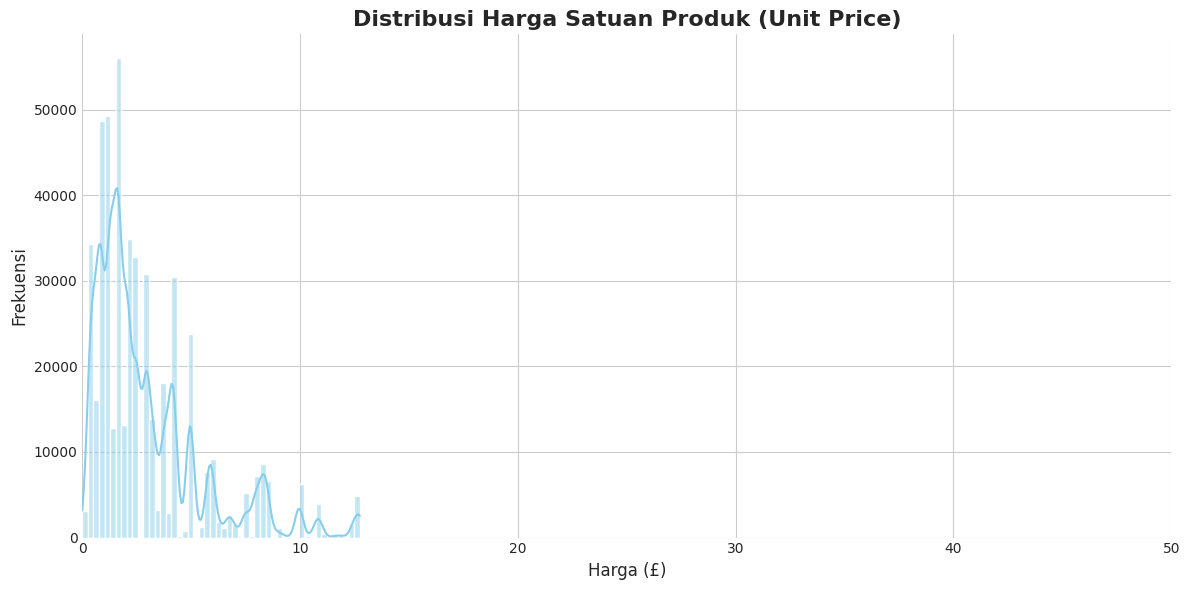

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup style
sns.set_style("whitegrid")

# Buat figure sendiri khusus untuk distribusi harga
plt.figure(figsize=(12, 6))

# Plot Histogram
sns.histplot(df_clean['UnitPrice'], bins=50, kde=True, color='skyblue')

# Judul dan Label
plt.title('Distribusi Harga Satuan Produk (Unit Price)', fontsize=16, fontweight='bold')
plt.xlabel('Harga (£)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xlim(0, 50) # Membatasi x-axis agar fokus pada mayoritas data (non-outlier)

plt.tight_layout()
plt.show()

### visualisasi top 10 produk

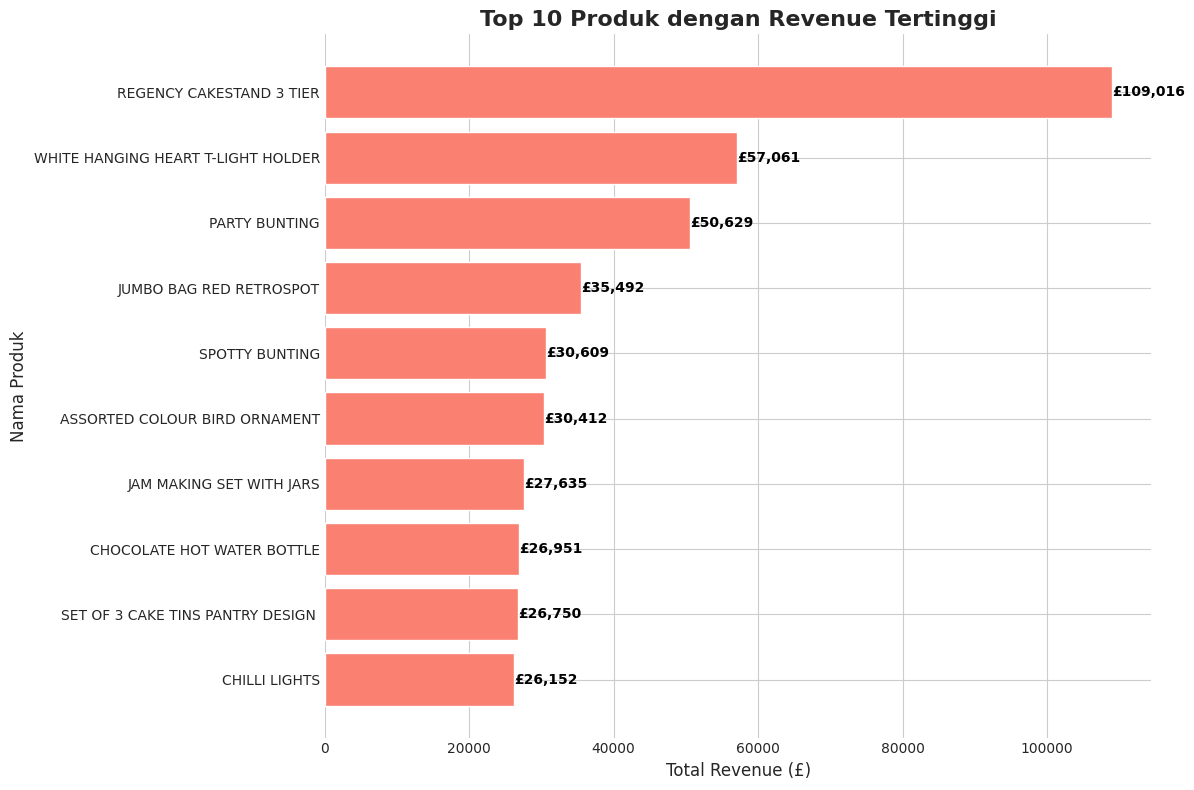

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure sendiri khusus untuk Top Products
plt.figure(figsize=(12, 8))

# Siapkan data (mengambil 10 teratas dan diurutkan agar bar chart rapi)
top_products_viz = top_products.head(10).sort_values('Total_Revenue', ascending=True)

# Plot Bar Chart Horizontal
bars = plt.barh(top_products_viz.index, top_products_viz['Total_Revenue'], color='salmon')

# Judul dan Label
plt.title('Top 10 Produk dengan Revenue Tertinggi', fontsize=16, fontweight='bold')
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.ylabel('Nama Produk', fontsize=12)

# Menambahkan label angka di ujung bar agar mudah dibaca
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'£{width:,.0f}', 
             va='center', ha='left', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

### visualisasi tren pendapatan bulanan

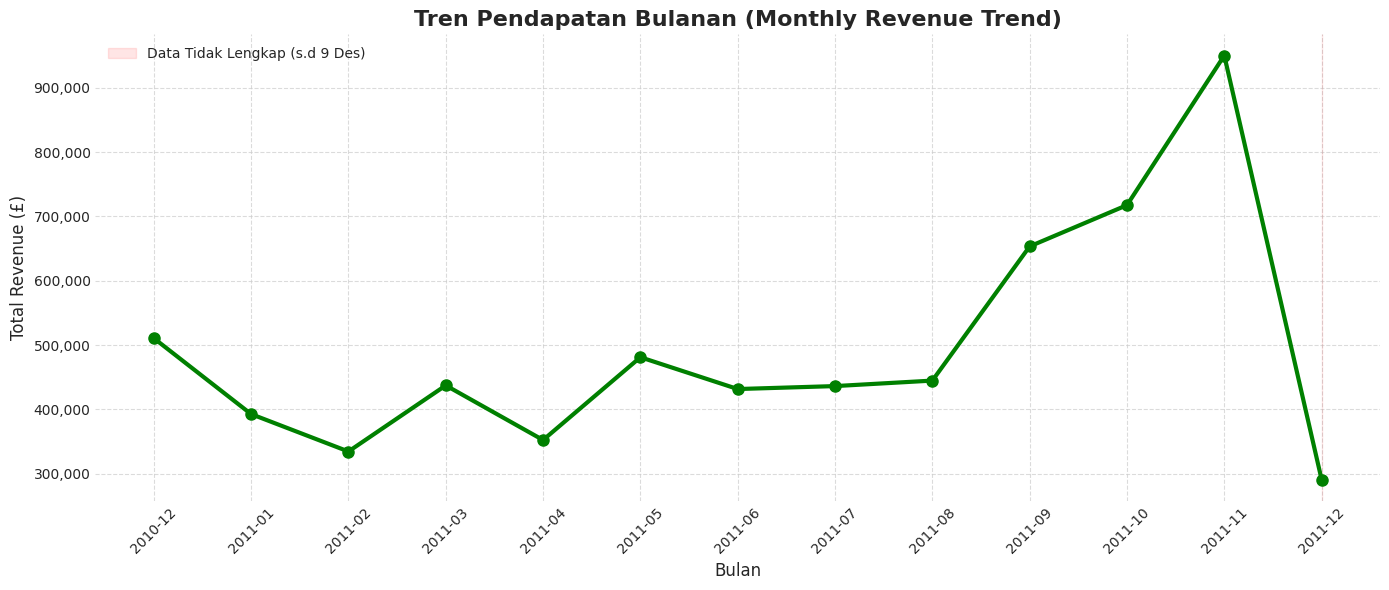

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure sendiri khusus untuk Tren Waktu
plt.figure(figsize=(14, 6))

# Mengelompokkan data berdasarkan Bulan
monthly_trend = df_clean.groupby(df_clean['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
monthly_trend.index = monthly_trend.index.astype(str)

# Plot Line Chart
plt.plot(monthly_trend.index, monthly_trend.values, marker='o', linestyle='-', color='green', linewidth=3, markersize=8)

# Highlight area penurunan di bulan Desember 2011 (karena data tidak lengkap)
plt.axvspan('2011-12', '2011-12', color='red', alpha=0.1, label='Data Tidak Lengkap (s.d 9 Des)')

# Judul dan Label
plt.title('Tren Pendapatan Bulanan (Monthly Revenue Trend)', fontsize=16, fontweight='bold')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format y-axis agar ada koma pemisah ribuan
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

visualisasi korelasi fitur / correlation heatmap

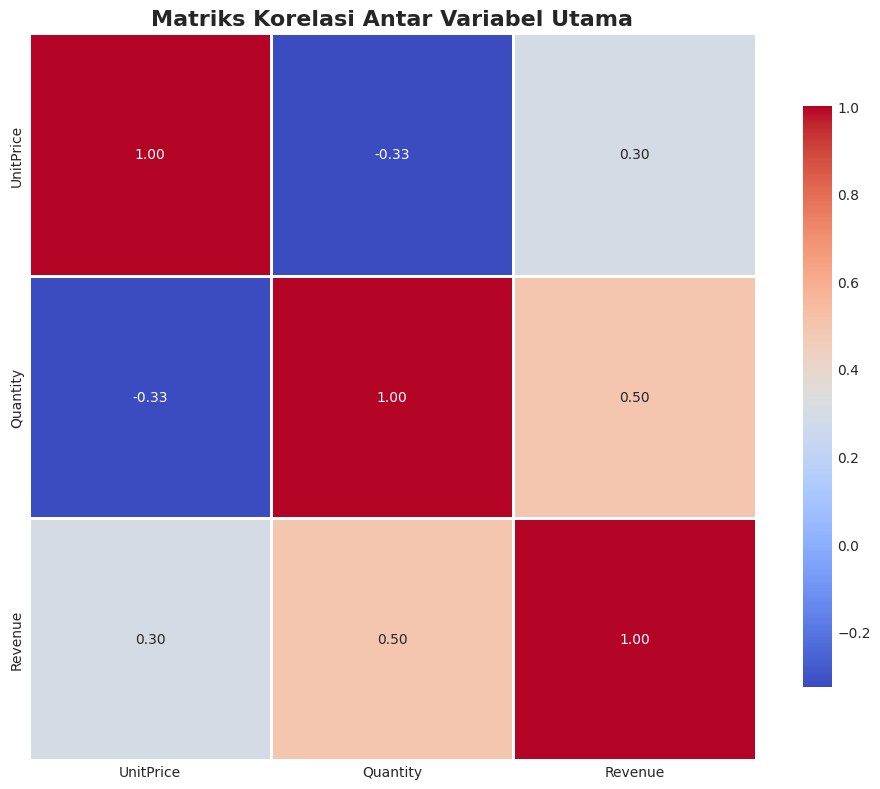

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure sendiri khusus untuk Heatmap
plt.figure(figsize=(10, 8))

# Mengambil kolom numerik relevan untuk korelasi
corr_cols = ['UnitPrice', 'Quantity', 'Revenue']
correlation = df_clean[corr_cols].corr()

# Plot Heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=1, square=True, cbar_kws={"shrink": .8})

# Judul
plt.title('Matriks Korelasi Antar Variabel Utama', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Feature Engineering
### Rekayasa Fitur

- **Agregasi produk** - Statistik per produk (harga, quantity, revenue)
- **Price volatility** - Volatilitas harga produk
- **Popularity score** - Skor popularitas produk
- **Product categorization** - Kategorisasi produk berdasarkan deskripsi
- **Elasticity proxy** - Indikator sensitivitas harga (price elasticity)


In [55]:
print(f"\n{'='*60}")
print("5. FEATURE ENGINEERING")
print("="*60)

print("\nMembuat fitur level produk...")

product_features = df_clean.groupby(['StockCode', 'Description']).agg({
    'UnitPrice': ['mean', 'std', 'min', 'max'],
    'Quantity': ['mean', 'sum', 'std'],
    'Revenue': ['sum', 'mean'],
    'InvoiceNo': 'count',
    'CustomerID': 'nunique',
    'Country': 'nunique'
}).reset_index()

product_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                            for col in product_features.columns.values]

product_features.columns = [
    'StockCode', 'Description', 
    'AvgPrice', 'StdPrice', 'MinPrice', 'MaxPrice',
    'AvgQuantity', 'TotalQuantitySold', 'StdQuantity',
    'TotalRevenue', 'AvgRevenue',
    'TransactionCount', 'UniqueCustomers', 'CountriesServed'
]

product_features['PriceVolatility'] = (product_features['StdPrice'] / 
                                       product_features['AvgPrice']).fillna(0)
product_features['PopularityScore'] = (product_features['TransactionCount'] * 
                                       product_features['UniqueCustomers'])
product_features['RevenuePerTransaction'] = (product_features['TotalRevenue'] / 
                                             product_features['TransactionCount'])
product_features['QuantityPerTransaction'] = (product_features['TotalQuantitySold'] / 
                                              product_features['TransactionCount'])

def categorize_product(description):
    """Mengkategorikan produk berdasarkan kata kunci dalam deskripsi"""
    description = str(description).upper()
    if any(word in description for word in ['CHRISTMAS', 'SANTA', 'TREE', 'DECORATION']):
        return 'Seasonal/Holiday'
    elif any(word in description for word in ['BAG', 'PURSE', 'LUGGAGE']):
        return 'Bags & Accessories'
    elif any(word in description for word in ['MUG', 'CUP', 'GLASS', 'PLATE', 'BOWL']):
        return 'Kitchenware'
    elif any(word in description for word in ['LIGHT', 'CANDLE', 'LAMP']):
        return 'Lighting'
    elif any(word in description for word in ['PAPER', 'CARD', 'WRAP', 'TISSUE']):
        return 'Stationery & Paper'
    elif any(word in description for word in ['TOY', 'GAME', 'CHILDREN']):
        return 'Toys & Games'
    elif any(word in description for word in ['FABRIC', 'CUSHION', 'TOWEL']):
        return 'Textiles'
    else:
        return 'General Merchandise'

product_features['Category'] = product_features['Description'].apply(categorize_product)

print(f"✓ Fitur level produk berhasil dibuat: {product_features.shape}")
print(f"\nDistribusi Kategori Produk:")
print(product_features['Category'].value_counts())

product_features['ElasticityProxy'] = np.where(
    product_features['AvgPrice'] > 0,
    product_features['PriceVolatility'] / np.log1p(product_features['AvgPrice']),
    0
)

elasticity_min = product_features['ElasticityProxy'].quantile(0.05)
elasticity_max = product_features['ElasticityProxy'].quantile(0.95)
product_features['NormalizedElasticity'] = 0.5 + 1.5 * (
    (product_features['ElasticityProxy'] - elasticity_min) / 
    (elasticity_max - elasticity_min)
).clip(0, 1)

print(f"\n✓ Feature engineering selesai!")
print(f"Total fitur: {product_features.shape[1]}")



5. FEATURE ENGINEERING

Membuat fitur level produk...
✓ Fitur level produk berhasil dibuat: (4080, 19)

Distribusi Kategori Produk:
Category
General Merchandise    2484
Kitchenware             382
Lighting                296
Stationery & Paper      289
Seasonal/Holiday        275
Bags & Accessories      218
Textiles                 93
Toys & Games             43
Name: count, dtype: int64

✓ Feature engineering selesai!
Total fitur: 21


---
## 6. Rule-Based Simulation for Jetto.id
### Simulasi Berbasis Aturan untuk Data Internal Jetto.id

- **Market-based pricing** - Harga dasar mengikuti pasar
- **Time-based pricing** - Penyesuaian harga berdasarkan waktu (weekend, peak hours)
- **Dynamic pricing strategy** - Strategi pricing dinamis berdasarkan demand
- **Price elasticity** - Pengaruh harga terhadap demand
- **Seasonal factors** - Faktor musiman (peak, normal, off season)


In [56]:
print(f"\n{'='*60}")
print("6. RULE-BASED SIMULATION FOR JETTO.ID DATA")
print("="*60)

jetto_catalog = product_features.nlargest(500, 'PopularityScore').copy()
print(f"\n✓ Dipilih {len(jetto_catalog)} produk untuk katalog Jetto.id")

np.random.seed(42)

n_transactions = 50000  
simulation_days = 365   
start_date = datetime(2024, 1, 1)

print(f"\nParameter Simulasi:")
print(f"  - Target Transaksi: {n_transactions:,}")
print(f"  - Periode Simulasi: {simulation_days} hari")
print(f"  - Tanggal Mulai: {start_date.date()}")



6. RULE-BASED SIMULATION FOR JETTO.ID DATA

✓ Dipilih 500 produk untuk katalog Jetto.id

Parameter Simulasi:
  - Target Transaksi: 50,000
  - Periode Simulasi: 365 hari
  - Tanggal Mulai: 2024-01-01


In [57]:
simulated_data = []

print(f"\nMenghasilkan transaksi simulasi...")

for i in range(n_transactions):
    product = jetto_catalog.sample(1).iloc[0]
    
    random_days = np.random.randint(0, simulation_days)
    transaction_date = start_date + timedelta(days=random_days)
    
    day_of_week = transaction_date.strftime('%A')
    hour = np.random.choice(range(8, 22), p=[0.03]*4 + [0.08]*4 + [0.12]*4 + [0.04]*2)
    is_weekend = day_of_week in ['Saturday', 'Sunday']
    is_peak_hour = hour in [18, 19, 20, 21]
    month = transaction_date.month
    
    if month in [11, 12, 1]:
        season = 'peak'
        seasonal_factor = 1.2
    elif month in [6, 7, 8]:
        season = 'off'
        seasonal_factor = 0.8
    else:
        season = 'normal'
        seasonal_factor = 1.0
    
    # ATURAN PRICING
    # Rule 1: Market-Based Pricing dengan variasi random
    base_price_market = product['AvgPrice']
    random_factor = np.random.uniform(-0.30, 0.30)    
    # Rule 2: Time-Based Pricing
    time_factor = 1.0
    if is_weekend:
        time_factor *= 1.03  # Premium weekend
    if is_peak_hour:
        time_factor *= 1.02  # Premium jam sibuk
    
    # Hitung harga pasar
    price_market = base_price_market * (1 + random_factor) * time_factor
    
    # ATURAN DEMAND
    # Rule 1: Base demand (rata-rata quantity)
    base_demand = max(1, product['AvgQuantity'])
    
    # Rule 2: Efek Seasonal & Temporal
    day_factor = 1.3 if is_weekend else 1.0
    demand_temporal = base_demand * seasonal_factor * day_factor
    
    # Rule 3: Strategi Dynamic Pricing untuk Jetto
    # Pricing kompetitif berdasarkan prediksi demand
    predicted_demand_level = demand_temporal / base_demand
    
    if predicted_demand_level < 0.8:  # Demand rendah
        price_jetto = price_market * 0.90  # Diskon 10%
    elif predicted_demand_level > 1.2:  # Demand tinggi
        price_jetto = price_market * 1.05  # Premium 5%
    else:  # Demand normal
        price_jetto = price_market
    
    # Rule 4: Price Elasticity of Demand
    price_ratio = price_jetto / base_price_market
    elasticity = product['NormalizedElasticity']
    demand_final = demand_temporal * (price_ratio ** (-elasticity))
    
    # Tambahkan noise random
    demand_final = max(1, demand_final * np.random.uniform(0.8, 1.2))
    
    # Rule 5: Efek Ketersediaan Stok
    stock_level = np.random.randint(5, 100)
    if stock_level < 10:
        demand_final *= 0.7
    
    # Hitung quantity terjual (bulatkan ke integer)
    quantity_sold = max(1, int(np.round(demand_final)))
    
    # Hitung revenue dan profit margin
    revenue = price_jetto * quantity_sold
    cost_estimate = price_market * 0.65  # Asumsi markup 35%
    profit_margin_pct = ((price_jetto - cost_estimate) / price_jetto * 100)
    
    # Simpan transaksi
    simulated_data.append({
        'transaction_id': f'JT-{transaction_date.strftime("%Y%m%d")}-{i+1:05d}',
        'product_id': product['StockCode'],
        'product_name': product['Description'],
        'product_category': product['Category'],
        'price_market': round(price_market, 2),
        'price_jetto': round(price_jetto, 2),
        'quantity_sold': quantity_sold,
        'demand_simulation': round(demand_final, 2),
        'transaction_date': transaction_date,
        'day_of_week': day_of_week,
        'hour_of_day': hour,
        'is_weekend': is_weekend,
        'is_peak_hour': is_peak_hour,
        'month': month,
        'season': season,
        'price_elasticity': round(elasticity, 3),
        'stock_level': stock_level,
        'revenue': round(revenue, 2),
        'profit_margin_pct': round(profit_margin_pct, 2)
    })
    
    # Progress indicator
    if (i + 1) % 10000 == 0:
        print(f"  Progress: {i+1:,} / {n_transactions:,} transaksi ({(i+1)/n_transactions*100:.1f}%)")

df_jetto = pd.DataFrame(simulated_data)

print(f"\n✓ Simulasi selesai!")
print(f"Berhasil generate {len(df_jetto):,} transaksi untuk Jetto.id")



Menghasilkan transaksi simulasi...
  Progress: 10,000 / 50,000 transaksi (20.0%)
  Progress: 20,000 / 50,000 transaksi (40.0%)
  Progress: 30,000 / 50,000 transaksi (60.0%)
  Progress: 40,000 / 50,000 transaksi (80.0%)
  Progress: 50,000 / 50,000 transaksi (100.0%)

✓ Simulasi selesai!
Berhasil generate 50,000 transaksi untuk Jetto.id


    ---
## 7. Analytics Base Table (ABT) Creation
### Pembuatan Tabel Dasar Analitik

ABT adalah tabel agregasi yang digunakan sebagai input untuk modeling:
- Agregasi per produk dengan statistik lengkap
- Fitur harga (market vs jetto, volatility, discount)
- Fitur penjualan (quantity, revenue, transaction count)
- Fitur temporal (weekend ratio, peak hour ratio)
- Fitur behavioral (elasticity)


In [58]:
print(f"\n{'='*60}")
print("7. ANALYTICS BASE TABLE (ABT) CREATION")
print("="*60)

# Buat fitur agregasi untuk modeling
abt = df_jetto.groupby('product_id').agg({
    'price_market': ['mean', 'std', 'min', 'max'],
    'price_jetto': ['mean', 'std', 'min', 'max'],
    'quantity_sold': ['sum', 'mean', 'std'],
    'revenue': ['sum', 'mean', 'std'],
    'transaction_id': 'count',
    'is_weekend': 'mean',
    'is_peak_hour': 'mean',
    'price_elasticity': 'first',
    'product_category': 'first',
    'product_name': 'first'
}).reset_index()

# Flatten columns
abt.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
               for col in abt.columns.values]

# Rename untuk kejelasan
abt.columns = [
    'product_id', 
    'market_price_mean', 'market_price_std', 'market_price_min', 'market_price_max',
    'jetto_price_mean', 'jetto_price_std', 'jetto_price_min', 'jetto_price_max',
    'total_quantity_sold', 'avg_quantity_sold', 'std_quantity_sold',
    'total_revenue', 'avg_revenue', 'std_revenue',
    'transaction_count',
    'weekend_ratio', 'peak_hour_ratio',
    'price_elasticity',
    'category', 'product_name'
]

# Tambahkan fitur kalkulasi
abt['price_discount_avg'] = ((abt['market_price_mean'] - abt['jetto_price_mean']) / 
                              abt['market_price_mean'] * 100)
abt['revenue_per_transaction'] = abt['total_revenue'] / abt['transaction_count']
abt['price_volatility'] = abt['jetto_price_std'] / abt['jetto_price_mean']

print(f"\n✓ Analytics Base Table berhasil dibuat!")
print(f"  Dimensi: {abt.shape}")
print(f"\nPreview ABT:")
print(abt.head())



7. ANALYTICS BASE TABLE (ABT) CREATION

✓ Analytics Base Table berhasil dibuat!
  Dimensi: (497, 24)

Preview ABT:
  product_id  market_price_mean  market_price_std  market_price_min  \
0      15036           1.153091          0.193280              0.79   
1     15056N           7.222883          1.240214              5.05   
2     16161P           0.420319          0.077549              0.30   
3      20675           1.619239          0.282155              1.14   
4      20676           1.674141          0.299227              1.18   

   market_price_max  jetto_price_mean  jetto_price_std  jetto_price_min  \
0              1.48          1.166091         0.198495             0.79   
1              9.58          7.336396         1.268530             5.05   
2              0.56          0.425213         0.079821             0.30   
3              2.15          1.636739         0.296356             1.14   
4              2.24          1.691616         0.303055             1.18   

   jet

---
## 8. Data Export
### Export Data ke File CSV

Export semua dataset yang telah diproses untuk digunakan pada tahap berikutnya:
1. **01_cleaned_market_data.csv** - Data pasar yang sudah dibersihkan
2. **02_product_features.csv** - Fitur level produk
3. **03_jetto_simulated_transactions.csv** - Data transaksi simulasi Jetto.id
4. **04_analytics_base_table.csv** - Tabel dasar untuk analitik dan modeling


In [59]:
print(f"\n{'='*60}")
print("8. DATA EXPORT")
print("="*60)

# Export datasets
df_clean.to_csv('01_cleaned_market_data.csv', index=False)
print("✓ Exported: 01_cleaned_market_data.csv")

product_features.to_csv('02_product_features.csv', index=False)
print("✓ Exported: 02_product_features.csv")

df_jetto.to_csv('03_jetto_simulated_transactions.csv', index=False)
print("✓ Exported: 03_jetto_simulated_transactions.csv")

abt.to_csv('04_analytics_base_table.csv', index=False)
print("✓ Exported: 04_analytics_base_table.csv")

print(f"\n✓ Semua file berhasil di-export!")



8. DATA EXPORT
✓ Exported: 01_cleaned_market_data.csv
✓ Exported: 02_product_features.csv
✓ Exported: 03_jetto_simulated_transactions.csv
✓ Exported: 04_analytics_base_table.csv

✓ Semua file berhasil di-export!


---
## 9. Summary Statistics
### Ringkasan Statistik Persiapan Data

Ringkasan lengkap dari seluruh proses persiapan data:
- Statistik data pasar original
- Statistik data simulasi Jetto.id
- Ringkasan Analytics Base Table (ABT)
- Status kesiapan untuk fase modeling


In [60]:
print(f"\n{'='*60}")
print("9. RINGKASAN PERSIAPAN DATA (DATA PREPARATION SUMMARY)")
print("="*60)

print(f"\nData Pasar Original:")
print(f"  - Total Transaksi: {len(df):,}")
print(f"  - Setelah Pembersihan: {len(df_clean):,}")
print(f"  - Produk Unik: {df_clean['StockCode'].nunique():,}")

print(f"\nData Simulasi Jetto.id:")
print(f"  - Total Transaksi: {len(df_jetto):,}")
print(f"  - Produk Unik: {df_jetto['product_id'].nunique():,}")
print(f"  - Rentang Tanggal: {df_jetto['transaction_date'].min().date()} s/d {df_jetto['transaction_date'].max().date()}")
print(f"  - Total Revenue: ${df_jetto['revenue'].sum():,.2f}")
print(f"  - Nilai Transaksi Rata-rata: ${df_jetto['revenue'].mean():.2f}")

print(f"\nAnalytics Base Table:")
print(f"  - Produk untuk Modeling: {len(abt)}")
print(f"  - Jumlah Fitur: {abt.shape[1]}")

print(f"\n{'='*60}")
print("✓ FASE PERSIAPAN DATA SELESAI!")
print("="*60)
print("\nSiap untuk Phase 2: Modeling")
print("File telah di-export dan siap untuk pipeline machine learning.")



9. RINGKASAN PERSIAPAN DATA (DATA PREPARATION SUMMARY)

Data Pasar Original:
  - Total Transaksi: 541,909
  - Setelah Pembersihan: 497,408
  - Produk Unik: 3,851

Data Simulasi Jetto.id:
  - Total Transaksi: 50,000
  - Produk Unik: 497
  - Rentang Tanggal: 2024-01-01 s/d 2024-12-30
  - Total Revenue: $851,483.83
  - Nilai Transaksi Rata-rata: $17.03

Analytics Base Table:
  - Produk untuk Modeling: 497
  - Jumlah Fitur: 24

✓ FASE PERSIAPAN DATA SELESAI!

Siap untuk Phase 2: Modeling
File telah di-export dan siap untuk pipeline machine learning.


---

### Hasil Persiapan Data
-  Data pasar dibersihkan dari anomali dan outlier
-  Fitur temporal, produk, dan harga telah di-ekstraksi
- 50,000 transaksi simulasi Jetto.id berhasil dibuat
-  Analytics Base Table (ABT) siap untuk modeling

### File Output
1. `01_cleaned_market_data.csv` - Dataset pasar bersih
2. `02_product_features.csv` - Fitur produk agregat
3. `03_jetto_simulated_transactions.csv` - Transaksi simulasi Jetto.id
4. `04_analytics_base_table.csv` - ABT untuk modeling


